## Import

In [11]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [9]:
import sccoda
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
import arviz as az

2025-11-20 14:56:58.206590: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 14:56:58.740649: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-20 14:57:01.903354: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [12]:
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
input_path = "../phenotype_classification/output_phenotypes"

## Load

In [3]:
adata = sc.read_h5ad(os.path.join(input_path, 'sc_phenotypes.h5ad'))

## Simplify annotation

In [4]:
adata.obs['celltype'] = adata.obs['cell_type_coarse'].astype(str)

In [5]:
adata.obs.loc[adata.obs['cell_type_middle'] == 'Fibroblast', 'celltype'] = 'Fibroblast'
adata.obs.loc[adata.obs['cell_type_middle'] == 'Endothelial cell', 'celltype'] = 'Endothelial cell'
adata.obs.loc[adata.obs['cell_type_middle'] == 'Macrophage', 'celltype'] = 'Macrophage'
adata.obs.loc[adata.obs['cell_type_middle'] == 'Dendritic cell', 'celltype'] = 'Dendritic cell'
adata.obs.loc[adata.obs['cell_type_middle'] == 'Neutrophil', 'celltype'] = 'Neutrophil'
adata.obs.loc[adata.obs['cell_type_middle'] == 'Mast cell', 'celltype'] = 'Mast cell'

In [6]:
adata.obs.loc[adata.obs['cell_type_middle'] == 'Pericyte', 'celltype'] = 'Fibroblast'
adata.obs.loc[adata.obs['cell_type_middle'] == 'Monocyte', 'celltype'] = 'Macrophage'
adata.obs.loc[adata.obs['cell_type_middle'] == 'Eosinophil', 'celltype'] = 'Neutrophil'
adata.obs.loc[adata.obs['cell_type_coarse'] == 'NK', 'celltype'] = 'T cell'
adata.obs.loc[adata.obs['cell_type_coarse'] == 'ILC', 'celltype'] = 'T cell'

In [19]:
adata.write(os.path.join(input_path, 'sc_phenotypes_unif_annotation.h5ad'))

## Inspection

In [7]:
phenotype_key = 'phenotype'
cell_type_key = 'celltype'
patient_key = 'patient_short'
tissue_region_key = 'tumor_source'

In [8]:
# exclude normal from analysis
adata_region = adata[adata.obs[tissue_region_key].isin(['core', 'border'])].copy()

In [16]:
adata_region.obs[cell_type_key].value_counts()

celltype
Cancer cell         15341
Neutrophil          10045
T cell               8092
Plasma cell          2641
Macrophage           2067
B cell               1348
Endothelial cell      895
Fibroblast            567
Dendritic cell        306
Mast cell             221
Epithelial cell       190
Schwann cell           19
Name: count, dtype: int64

In [17]:
adata_region.obs[patient_key].value_counts()

patient_short
P5     7543
P14    5544
P9     5296
P7     4741
P4     3212
P3     3101
P13    3081
P16    2734
P8     2668
P12    2279
P11    1533
Name: count, dtype: int64

In [44]:
adata_region.obs[phenotype_key].value_counts()

phenotype
inflamed    16188
ignored     13702
excluded    11842
Name: count, dtype: int64

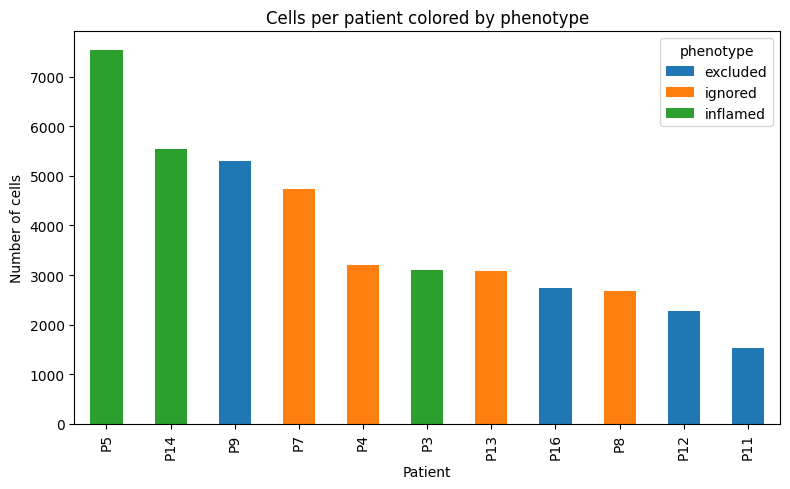

In [55]:
ct = pd.crosstab(adata_region.obs[patient_key], adata_region.obs[phenotype_key])
ct = ct.loc[ct.sum(axis=1).sort_values(ascending=False).index]

ax = ct.plot(kind="bar",stacked=True,figsize=(8,5))
plt.xlabel("Patient")
plt.ylabel("Number of cells")
plt.title("Cells per patient colored by phenotype")
plt.tight_layout()
plt.show()

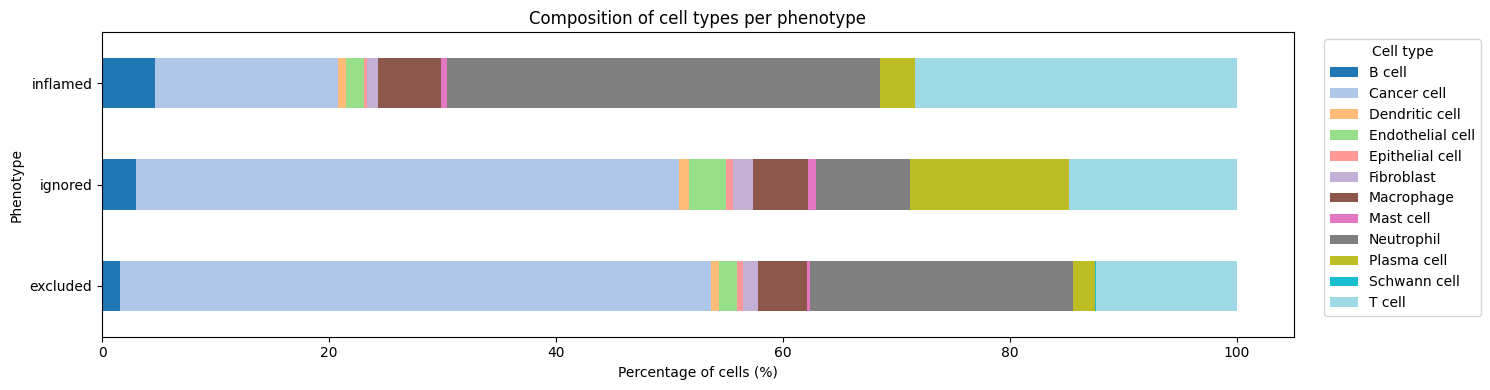

In [56]:
ct = pd.crosstab(adata_region.obs[phenotype_key], adata_region.obs[cell_type_key])
ct_percent = ct.div(ct.sum(axis=1), axis=0) * 100

ax = ct_percent.plot(kind='barh',stacked=True,figsize=(15,4),colormap='tab20')
plt.xlabel('Percentage of cells (%)')
plt.ylabel('Phenotype')
plt.title('Composition of cell types per phenotype')
plt.legend(title='Cell type', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

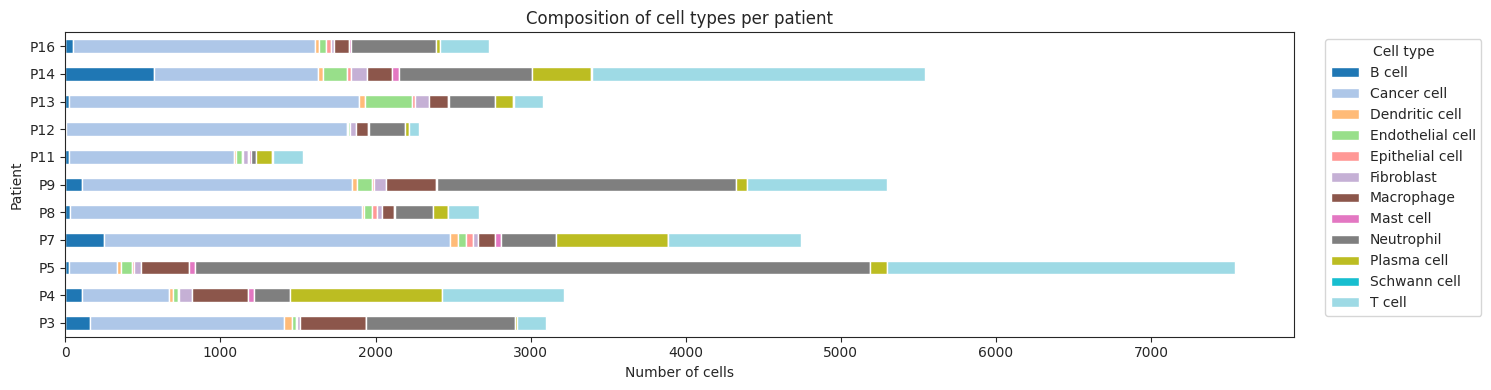

In [46]:
ct = pd.crosstab(adata_region.obs[patient_key], adata_region.obs[cell_type_key])
#ct_percent = ct.div(ct.sum(axis=1), axis=0) * 100

ax = ct.plot(kind='barh',stacked=True,figsize=(15,4),colormap='tab20')
plt.xlabel('Number of cells')
plt.ylabel('Patient')
plt.title('Composition of cell types per patient')
plt.legend(title='Cell type', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

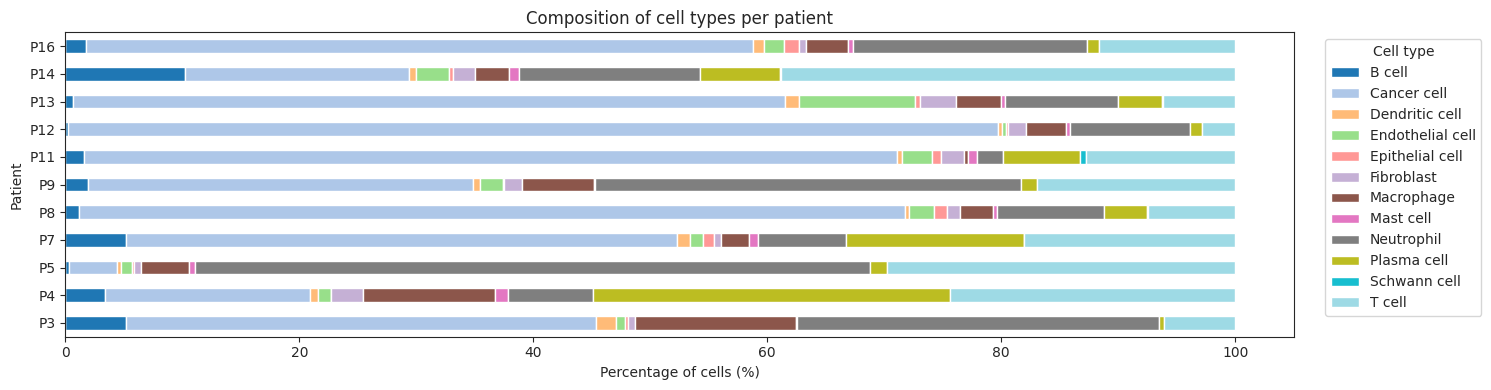

In [45]:
ct = pd.crosstab(adata_region.obs[patient_key], adata_region.obs[cell_type_key])
ct_percent = ct.div(ct.sum(axis=1), axis=0) * 100

ax = ct_percent.plot(kind='barh',stacked=True,figsize=(15,4),colormap='tab20')
plt.xlabel('Percentage of cells (%)')
plt.ylabel('Patient')
plt.title('Composition of cell types per patient')
plt.legend(title='Cell type', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

In [50]:
ct = pd.crosstab(adata_region.obs[patient_key], adata_region.obs[cell_type_key])
tot_cell = ct.sum(axis=1)
phenotype_map = adata_region.obs[[patient_key, phenotype_key]].drop_duplicates().set_index(patient_key)
ct['phenotype'] = phenotype_map[phenotype_key]

ct['total_cells'] = tot_cell
ct = ct.sort_values(['phenotype', 'total_cells'], ascending=[True, False])

phenotype_labels = ct['phenotype']
ct = ct.drop(columns=['phenotype', 'total_cells'])

ct_percent = ct.div(ct.sum(axis=1), axis=0) * 100

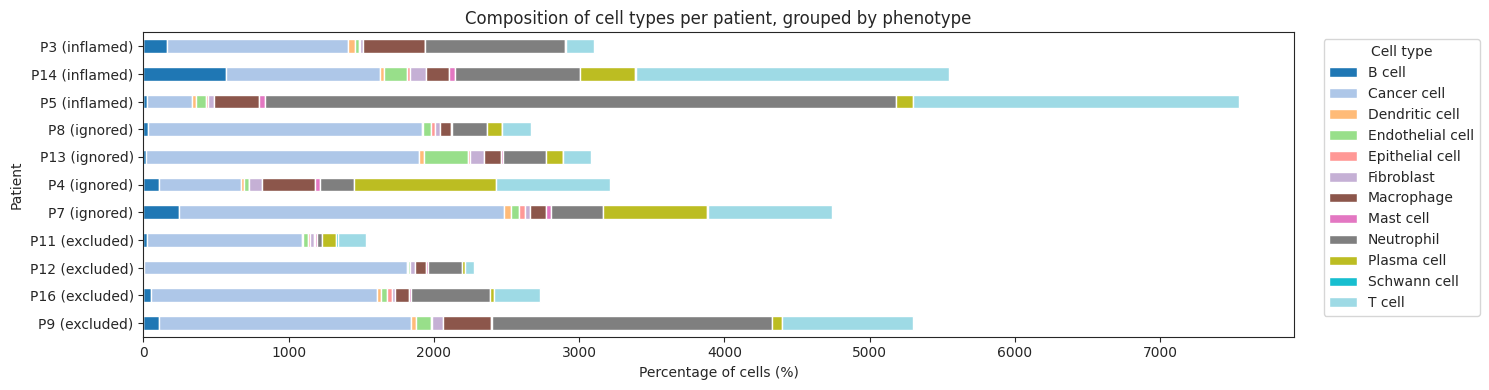

In [66]:
ax = ct.plot(kind='barh', stacked=True, figsize=(15,4), colormap='tab20')

ax.set_yticklabels([f"{p} ({phen})" for p, phen in zip(ct_percent.index, phenotype_labels)])
plt.xlabel('Percentage of cells (%)')
plt.ylabel('Patient')
plt.title('Composition of cell types per patient, grouped by phenotype')
plt.legend(title='Cell type', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

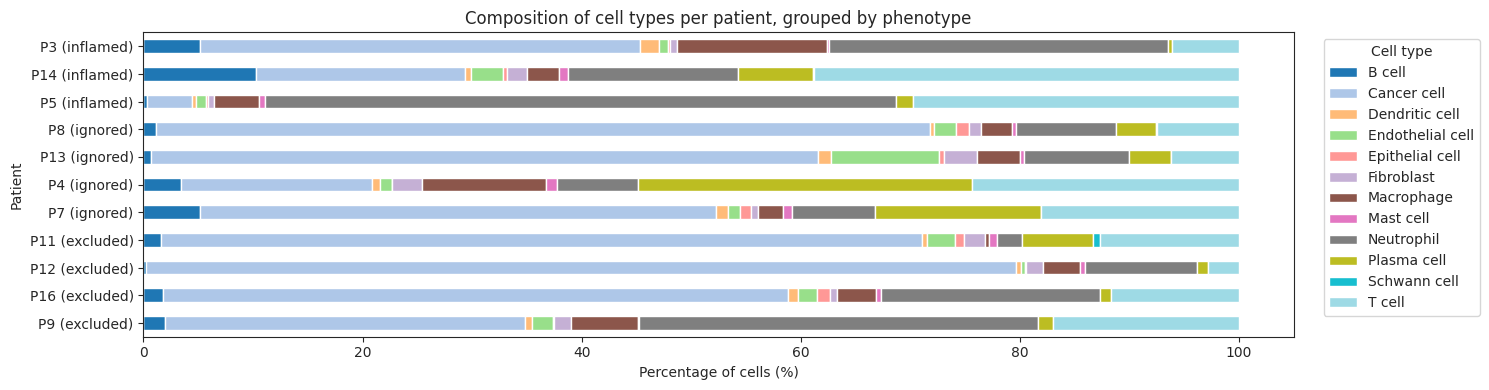

In [67]:
ax = ct_percent.plot(kind='barh', stacked=True, figsize=(15,4), colormap='tab20')

ax.set_yticklabels([f"{p} ({phen})" for p, phen in zip(ct_percent.index, phenotype_labels)])
plt.xlabel('Percentage of cells (%)')
plt.ylabel('Patient')
plt.title('Composition of cell types per patient, grouped by phenotype')
plt.legend(title='Cell type', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

## scCODA

### excluded vs inflamed

In [13]:
# retain only inflamed and exluded for now
adata_infl_excl = adata_region[adata_region.obs[phenotype_key].isin(['inflamed', 'excluded'])].copy()

In [14]:
cell_counts_per_patient_infl_excl = (adata_infl_excl.obs.groupby([patient_key, cell_type_key]).size().unstack())
cell_counts_per_patient_infl_excl[phenotype_key] = adata_infl_excl.obs.groupby(patient_key)[phenotype_key].first()

In [15]:
# Convert data to anndata object
adata_sccoda_infl_excl = dat.from_pandas(cell_counts_per_patient_infl_excl, covariate_columns=[phenotype_key])
adata_sccoda_infl_excl

AnnData object with n_obs × n_vars = 7 × 12
    obs: 'phenotype'

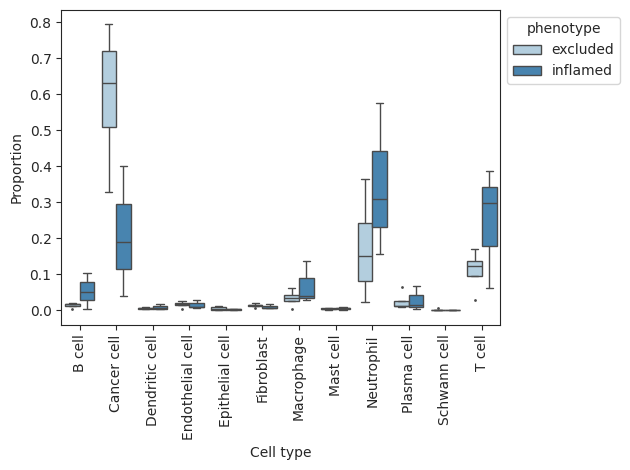

In [16]:
viz.boxplots(adata_sccoda_infl_excl, feature_name=phenotype_key)
plt.show()

In [17]:
model_infl_excl = mod.CompositionalAnalysis(adata_sccoda_infl_excl, formula=phenotype_key, reference_cell_type='Cancer cell')

Zero counts encountered in data! Added a pseudocount of 0.5.


W0000 00:00:1763647193.492903  695485 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [18]:
results_infl_excl = model_infl_excl.sample_hmc(num_results=100000) # more repetitions

  0%|          | 0/100000 [00:00<?, ?it/s]2025-11-20 14:59:57.944066: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f35f0097d60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-11-20 14:59:57.944090: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2025-11-20 14:59:58.003057: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763647198.600441  696981 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 100000/100000 [05:44<00:00, 289.91it/s]


MCMC sampling finished. (365.183 sec)
Acceptance rate: 43.0%


In [58]:
results_infl_excl.set_fdr(est_fdr=0.4) # without: zero significant
results_infl_excl.summary()

Compositional Analysis summary:

Data: 7 samples, 12 cell types
Reference index: 1
Formula: phenotype

Intercepts:
                  Final Parameter  Expected Sample
Cell Type                                         
B cell                     -0.606       171.544910
Cancer cell                 1.534      1458.035260
Dendritic cell             -2.050        40.481501
Endothelial cell           -0.680       159.308902
Epithelial cell            -1.237        91.272095
Fibroblast                 -0.748       148.836010
Macrophage                 -0.271       239.809557
Mast cell                  -1.169        97.694484
Neutrophil                  0.858       741.626017
Plasma cell                -0.518       187.325004
Schwann cell               -1.736        55.414711
T cell                      0.668       613.294409


Effects:
                                        Final Parameter  Expected Sample  \
Covariate             Cell Type                                            
phenotyp

In [42]:
#az.summary(results_infl_excl, var_names=["beta"], round_to=3)

### ignored vs inflamed

In [26]:
adata_infl_ign = adata[adata.obs[phenotype_key].isin(['inflamed', 'ignored'])].copy()

In [27]:
cell_counts_per_patient_infl_ign = (adata_infl_ign.obs.groupby([patient_key, cell_type_key]).size().unstack())
cell_counts_per_patient_infl_ign[phenotype_key] = adata_infl_ign.obs.groupby(patient_key)[phenotype_key].first()

In [28]:
# Convert data to anndata object
adata_sccoda_infl_ign = dat.from_pandas(cell_counts_per_patient_infl_ign, covariate_columns=[phenotype_key])
adata_sccoda_infl_ign

AnnData object with n_obs × n_vars = 7 × 12
    obs: 'phenotype'

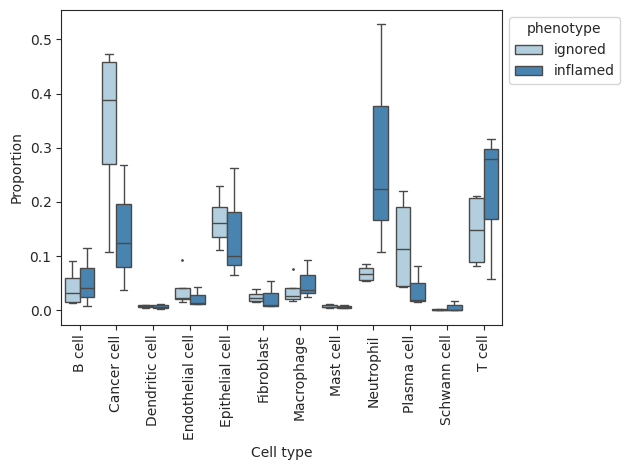

In [29]:
viz.boxplots(adata_sccoda_infl_ign, feature_name=phenotype_key)
plt.show()

In [30]:
model_infl_ign = mod.CompositionalAnalysis(adata_sccoda_infl_ign, formula=phenotype_key, reference_cell_type='Cancer cell')

Zero counts encountered in data! Added a pseudocount of 0.5.


In [31]:
results_infl_ign = model_infl_ign.sample_hmc(num_results=100000) # more repetitions

100%|██████████| 100000/100000 [06:03<00:00, 274.82it/s]


MCMC sampling finished. (383.717 sec)
Acceptance rate: 55.2%


In [60]:
results_infl_ign.set_fdr(est_fdr=0.4)  # without: zero significant
results_infl_ign.summary()

Compositional Analysis summary:

Data: 7 samples, 12 cell types
Reference index: 1
Formula: phenotype

Intercepts:
                  Final Parameter  Expected Sample
Cell Type                                         
B cell                      0.002       307.256671
Cancer cell                 1.443      1298.134432
Dendritic cell             -0.812       136.139958
Endothelial cell           -0.139       266.849135
Epithelial cell             1.180       997.930326
Fibroblast                 -0.266       235.023019
Macrophage                  0.069       328.548169
Mast cell                  -0.798       138.059322
Neutrophil                  0.798       681.082511
Plasma cell                 0.506       508.610990
Schwann cell               -1.441        72.579569
T cell                      1.181       998.928756


Effects:
                                        Final Parameter  Expected Sample  \
Covariate             Cell Type                                            
phenotyp

In [55]:
#az.summary(results_infl_ign, var_names=["beta"], round_to=3)

## scCODA - ignored vs excluded

In [34]:
adata_excl_ign = adata[adata.obs[phenotype_key].isin(['excluded', 'ignored'])].copy()

In [35]:
cell_counts_per_patient_excl_ign = (adata_excl_ign.obs.groupby([patient_key, cell_type_key]).size().unstack())
cell_counts_per_patient_excl_ign[phenotype_key] = adata_excl_ign.obs.groupby(patient_key)[phenotype_key].first()

In [36]:
# Convert data to anndata object
adata_sccoda_excl_ign = dat.from_pandas(cell_counts_per_patient_excl_ign, covariate_columns=[phenotype_key])
adata_sccoda_excl_ign

AnnData object with n_obs × n_vars = 8 × 12
    obs: 'phenotype'

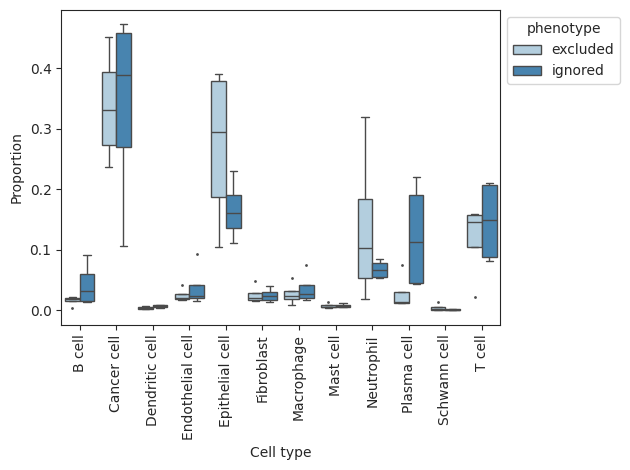

In [37]:
viz.boxplots(adata_sccoda_excl_ign, feature_name=phenotype_key)
plt.show()

In [38]:
model_excl_ign = mod.CompositionalAnalysis(adata_sccoda_excl_ign, formula=phenotype_key, reference_cell_type='Cancer cell')

Zero counts encountered in data! Added a pseudocount of 0.5.


In [39]:
results_excl_ign = model_excl_ign.sample_hmc(num_results=100000) # more repetitions

100%|██████████| 100000/100000 [06:14<00:00, 267.18it/s]


MCMC sampling finished. (528.966 sec)
Acceptance rate: 62.7%


In [64]:
results_excl_ign.set_fdr(est_fdr=0.4)
results_excl_ign.summary()

Compositional Analysis summary:

Data: 8 samples, 12 cell types
Reference index: 1
Formula: phenotype

Intercepts:
                  Final Parameter  Expected Sample
Cell Type                                         
B cell                     -0.063       156.742269
Cancer cell                 2.255      1591.771550
Dendritic cell             -0.742        79.487745
Endothelial cell            0.129       189.919986
Epithelial cell             1.868      1080.957885
Fibroblast                  0.065       178.145896
Macrophage                  0.125       189.161823
Mast cell                  -0.613        90.432422
Neutrophil                  0.975       442.571865
Plasma cell                 0.359       239.033296
Schwann cell               -1.246        48.019293
T cell                      1.262       589.693469


Effects:
                                       Final Parameter  Expected Sample  \
Covariate            Cell Type                                            
phenotype[

In [65]:
#az.summary(results_excl_ign, var_names=["beta"], round_to=3)